# AdTracking Fraud Detection

In [2]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas import Series, DataFrame, Panel


The goal of this project is to accurately predict the probability that a click on a mobile app ad leads to a download of the app.

Let's take a look at the data! For the purposes of this exploratory exercise, I'm using a subset (n = 100,000) of the original.

We see that each row represents a unique instance of a click. We also have an IP address, device (type of phone), operating system, channel (advertising medium), click time, attributed time (time of app download), and whether that initial click led to a download ('is_attributed').

TalkingData provides the following descriptions of the variables:

* ip: ip address of click.
* app: app id for marketing.
* device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* os: os version id of user mobile phone
* channel: channel id of mobile ad publisher
* click_time: timestamp of click (UTC)
* attributed_time: if user download the app for after clicking an ad, this is the time of the app download
* is_attributed: the target that is to be predicted, indicating the app was downloaded
* Note that ip, app, device, os, and channel are encoded.

In [3]:
# Read in the sample training data frame (n = 100,000)
df = pd.read_csv("train_sample.csv")
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


It is probably prudent to assume at this point that a single IP address does not necessarily represent a single user. Furthermore, it's not exactly clear just yet how attributed_time and click_time interact (e.g. does a download have to occur as a result of the most recent click through? Or can a download the next day be attributed to that first clickthrough?). This will be explored in more detail shortly.

## Explanatory variable distributions

### IP address

The number of unique IP addresses in this sample is about 1/3 of the total size.

In [24]:
len(df['ip'].value_counts())

34857

Some IP addresses have hundreds of clicks registered. This is not necessarily an indication of fraud, since each IP could be used by multiple people (through, for instance, dynamic IP assignment). The overwhelming majority of IP addresses have less than 10 clicks each.

Text(0.5,1,'Distribution of number of clicks per unique IP ')

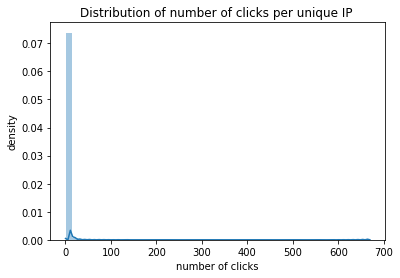

In [11]:
plot = sns.distplot(df['ip'].value_counts())
plot.set(ylabel = 'density')
plot.set(xlabel = 'number of clicks')
plot.set_title("Distribution of number of clicks per unique IP ")

### App

161 unique app IDs (i.e. different app advertisers). About 95% of the sample is comprised of the 20 most common app IDs, which is a fairly top-heavy distribution.

In [43]:
len(df['app'].value_counts())

161

In [44]:
sum(df['app'].value_counts().iloc[:20])/100000

0.94827

Text(0.5,1,'Distribution of number of clicks per app')

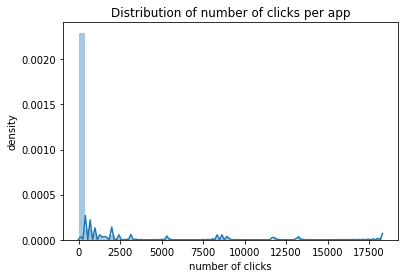

In [14]:
plot = sns.distplot(df['app'].value_counts())
plot.set(ylabel = 'density')
plot.set(xlabel = 'number of clicks')
plot.set_title("Distribution of number of clicks per app")

### Device

100 unique device ids. Almost 99% of the sample is comprised of 2 device types. Given that different versions of the same brand / model can be classed into distinct IDs, the level of homogeneity is surprising as you'd expect more spread amongst device types.

In [45]:
len(df['device'].value_counts())

100

In [50]:
sum(df['device'].value_counts().iloc[:2])/100000

0.98683

In [59]:
df['device'].value_counts().head(5)

1       94338
2        4345
0         541
3032      371
3543      151
Name: device, dtype: int64

### Operating system

130 unique operating systems. Almost 95% of the sample is comprised of the most common 30 operating systems. Nothing unusual here.

In [52]:
len(df['os'].value_counts())

130

In [56]:
sum(df['os'].value_counts().iloc[:30])/100000

0.94908

Text(0.5,1,'Distribution of number of clicks per OS')

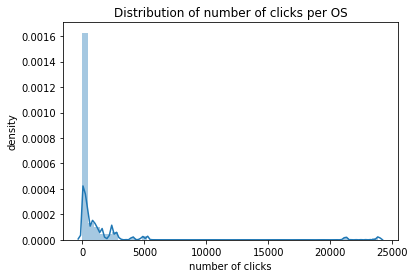

In [16]:
plot = sns.distplot(df['os'].value_counts())
plot.set(ylabel = 'density')
plot.set(xlabel = 'number of clicks')
plot.set_title("Distribution of number of clicks per OS")

### Channel

161 different channels. 99% of the sample is captured by the top 100 channels. Not a huge degree of concentration in channels. This is perhaps expected, as no one channel is the perfect medium to distribute advertisement spend.

In [57]:
len(df['channel'].value_counts())

161

In [63]:
sum(df['channel'].value_counts().iloc[:100])/100000

0.989

Text(0.5,1,'Distribution of number of clicks per channel')

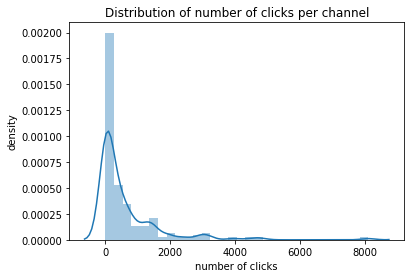

In [17]:
plot = sns.distplot(df['channel'].value_counts())
plot.set(ylabel = 'density')
plot.set(xlabel = 'number of clicks')
plot.set_title("Distribution of number of clicks per channel")

### Time 

There is much to explore when considering the time dimension of the problem.

Looking first at overall clicks per second, we can get a general sense of the timing.

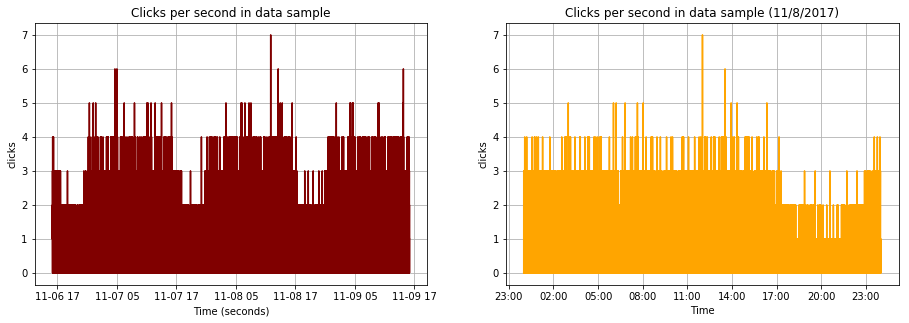

In [9]:
# Start and end date of the range
min_date = pd.to_datetime(df['click_time']).min()
max_date = pd.to_datetime(df['click_time']).max()

# Create a time series from start to end of the range consisting of clicks per second
dates = pd.date_range(start=min_date, end=max_date, freq='S')
date_series = Series(0, index=dates).fillna(0)

click_df = df['click_time'].value_counts()
click_series = Series(click_df, index = pd.to_datetime(click_df.index))
final_series = pd.Series.align(date_series, click_series, join = 'left')[1].fillna(0)

# Plot the total clicks per second for the whole date range, as well as for 1 day

plt.subplot(221)
plt.plot(final_series, 'maroon')
plt.xlabel('Time (seconds)')
plt.ylabel('clicks')
plt.ylabel('clicks')
plt.title('Clicks per second in data sample')
plt.grid(True)

ax = plt.subplot(222)
ax.plot(final_series['2017-11-08 00:00:00':'2017-11-08 23:59:59'], 'orange')
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Time')
plt.ylabel('clicks')
plt.title('Clicks per second in data sample (11/8/2017)')
plt.grid(True)

plt.subplots_adjust(left = 1, right = 3, bottom = 0, top = 2)
plt.show()


There seems to be seasonality in the data, with no trend evident. The max number of clicks per second in this sample appears to be 7. There's a lot of noise at this level of granularity, so perhaps using a different scale may help to add more perspective.

I will repeat the above plots using intervals of minutes.

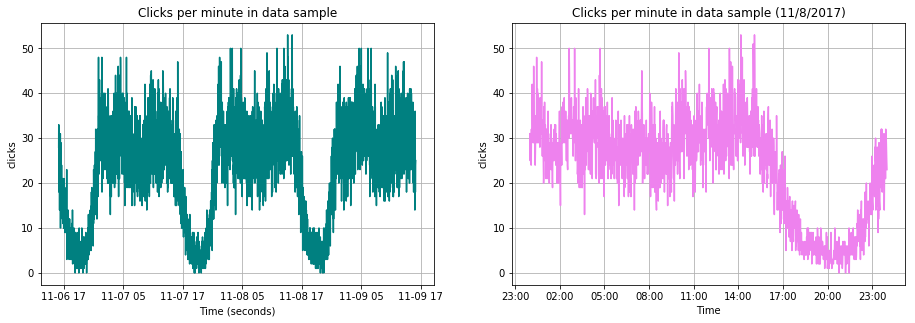

In [18]:
# Collapse the series into 1 minute intervals
minute_series = final_series.resample('60S').sum()

# Plot the total clicks per second for the whole date range, as well as for 1 day
plt.subplot(221)
plt.plot(minute_series, 'teal')
plt.xlabel('Time (seconds)')
plt.ylabel('clicks')
plt.ylabel('clicks')
plt.title('Clicks per minute in data sample')
plt.grid(True)

ax = plt.subplot(222)
ax.plot(minute_series['2017-11-08 00:00:00':'2017-11-08 23:59:59'], 'violet')
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Time')
plt.ylabel('clicks')
plt.title('Clicks per minute in data sample (11/8/2017)')
plt.grid(True)

plt.subplots_adjust(left = 1, right = 3, bottom = 0, top = 2)
plt.show()

The seasonality is now easier to interpret. Activity clearly starts dipping around the 5 pm mark and remains low until around midnight. I would have expected a longer period of inactivity, and it's not exactly clear why activity picks up around midnight. Furthermore, for a process with a good deal of expected randomness, the pattern of clicks is quite similar from day to day (see chart below).

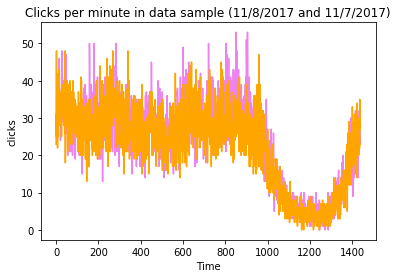

In [30]:
# Converted series to arrays to superimpose the lines
plt.plot(np.array(minute_series['2017-11-08 00:00:00':'2017-11-08 23:59:59']), 'violet')
plt.xlabel('Time')
plt.ylabel('clicks')
plt.title('Clicks per minute in data sample (11/8/2017 and 11/7/2017)')

plt.plot(np.array(minute_series['2017-11-07 00:00:00':'2017-11-07 23:59:59']), 'orange')